In [1]:
import os
os.chdir('../app')

In [2]:
import frontend.stock_analytics as salib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime,timedelta
from pprint import pprint
import matplotlib.patches as patches
import time
import numpy as np
import datetime
import copy
import preprocessing.lob.s03_fill_cache as l03
import preprocessing.preglobal as pg
%matplotlib inline

In [3]:
# Load all Graphs
sa_array = []
for i in pg.get_kn_entries({'selected':1}):
    print('load',i['id'])
    sa_array.append({'kn':i,'sa':salib.stock_analytics(i['id'], gui_mode=False)})
sa = sa_array[0]['sa']

mongo mongodb://192.168.0.94:27017/
load 20190910_AAPL
redis 192.168.0.94
load 20190325_AAPL
redis 192.168.0.94
load 20181030_AAPL
redis 192.168.0.94
load 20180912_AAPL
redis 192.168.0.94
load 20180604_AAPL
redis 192.168.0.94
load 20180327_AAPL
redis 192.168.0.94
load 20170912_AAPL
redis 192.168.0.94
load 20170605_AAPL
redis 192.168.0.94
load 20161027_AAPL
redis 192.168.0.94
load 20160907_AAPL
redis 192.168.0.94
load 20160613_AAPL
redis 192.168.0.94
load 20160321_AAPL
redis 192.168.0.94
load 20150909_AAPL
redis 192.168.0.94
load 20150608_AAPL
redis 192.168.0.94
load 20150309_AAPL
redis 192.168.0.94


In [4]:
salib.time_as_string = False
filte = copy.deepcopy(sa.filters['default'])

In [5]:
def draw_graph(g,f, draw=True):    
    res = sa.calculate_graph(g,f, histogram=True)
    if not draw:
        return
    
    if 'type' in g and g['type'] == 'heatmap':
        plt.imshow(res[0], aspect='auto')
        return
        
    x,y=res

    plt.rcParams['figure.figsize'] = (15, 8)
    plt.figure()
    plt.title(g['name'])
    plt.plot(x,y)
    
    if type(x[0]) in (datetime.datetime, datetime.date):
        myFmt = mdates.DateFormatter('%H:%M:%S')
        plt.gca().xaxis.set_major_formatter(myFmt)
        
    plt.show()
    return x,y

In [6]:
def xticks(xaxis, no_labels=5, mapf=None, isy=False):
    x = np.array(xaxis)
    nx = x.shape[0]

    step_x = int(nx / (no_labels - 1)) # step between consecutive labels
    x_positions = np.arange(0,nx,step_x) # pixel count at label position
    x_labels = x[::step_x] # labels you want to see
    if mapf:
        x_labels = mapf(x_labels)
    f = plt.yticks if isy else plt.xticks
    f(x_positions, x_labels)
def yticks(xaxis, no_labels=5,  mapf=None):
    xticks(xaxis=xaxis,no_labels=no_labels, mapf=mapf,isy=True)

In [7]:

def timetoimshowaxis(t, xaxis):
    scale = xaxis[1]-xaxis[0] # equals 1
    offset = xaxis[0]
    return -0.5 + (t-offset)/scale


In [8]:
def draw_graph_2d(g,f, draw=True, normalize=False, mapf=None):
    res = []
    xaxis = None
    yaxis = []
    for sa in sa_array:
        t = sa['sa'].calculate_graph(g,f, histogram=True)
        
        if not ( xaxis is None or xaxis == t[0]):
            assert len(xaxis) > len(t[0])
            print( 'axis not same length')
            while len(t[0]) != len(xaxis):
                for i in range(0,len(t[0])):
                    if xaxis[i] != t[0][i]:
                        t = (np.insert(t[0], i, xaxis[i]), np.insert(t[1], i, 0))
                        break
            assert (t[0] == xaxis).all(), (t[0], xaxis)
        
        if not xaxis:
            xaxis = t[0]
        res.append(np.array(t[1],dtype=float))
        yaxis.append(sa['kn']['id'])

    if not draw:
        return res, xaxis, yaxis
    
    if mapf:
        for i in range(len(res)):
            res[i] = mapf(res[i])
            
    if normalize:
        for i in range(len(res)):
            res[i] /= res[i].mean()

    plt.rcParams['figure.figsize'] = (15, 8)
    plt.figure()
    plt.title(g['name'])

    plt.imshow(res, aspect='auto', cmap=plt.get_cmap("tab20b"))
    xticks(xaxis, no_labels=12, mapf=lambda arr:[i.strftime("%H:%M:%S") for i in arr])
    yticks(yaxis,no_labels=len(yaxis))
    plt.colorbar() 
    ax = plt.gca()
    
    ttia = lambda x : timetoimshowaxis(x, xaxis) # abbreviation
    assert ttia(xaxis[0])==-0.5
    assert ttia(xaxis[len(xaxis)-1])==-0.5+len(xaxis)-1
    for i in range(len(sa_array)):
        sa = sa_array[i]
        # Create a Rectangle patch
        sstart = sa['kn']['time_mapping'][0]['stock_time_start']
        sstop = sa['kn']['time_mapping'][-1]['stock_time_end']
        start = salib.to_date_i(sstart)
        stop = salib.to_date_i(sstop)
        rect = patches.Rectangle((ttia(start),-0.5+i),ttia(stop)-ttia(start),1,
                                 linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.xlabel('Starting Time of each bin')
    
    return res, xaxis, yaxis, sstart, sstop    


In [9]:
filte['numbins']=100
filte['range']['time'] = [9.6*3600*1000, 15.9*3600*1000]

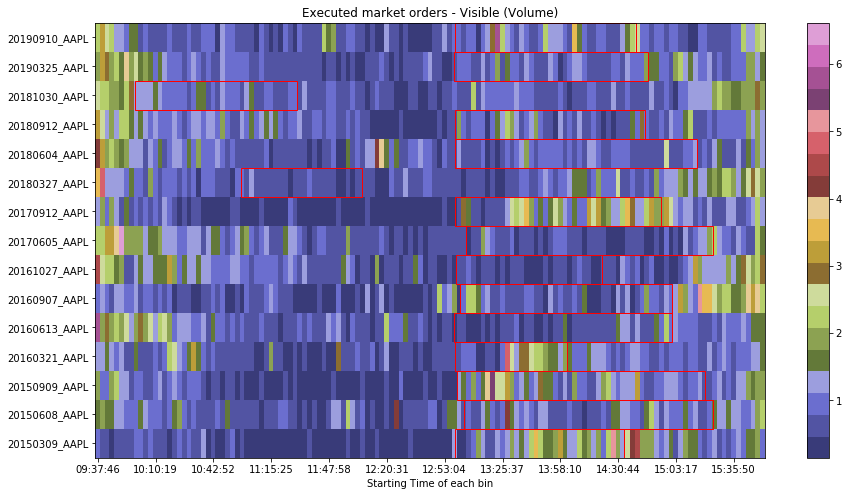

In [10]:

_ = draw_graph_2d(sa.graphlist['marketorder_vis'], filte, normalize=True)   


axis not same length


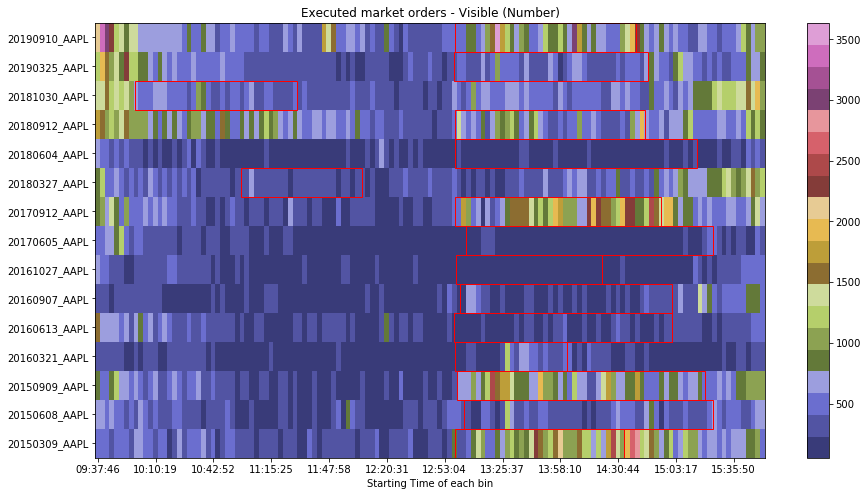

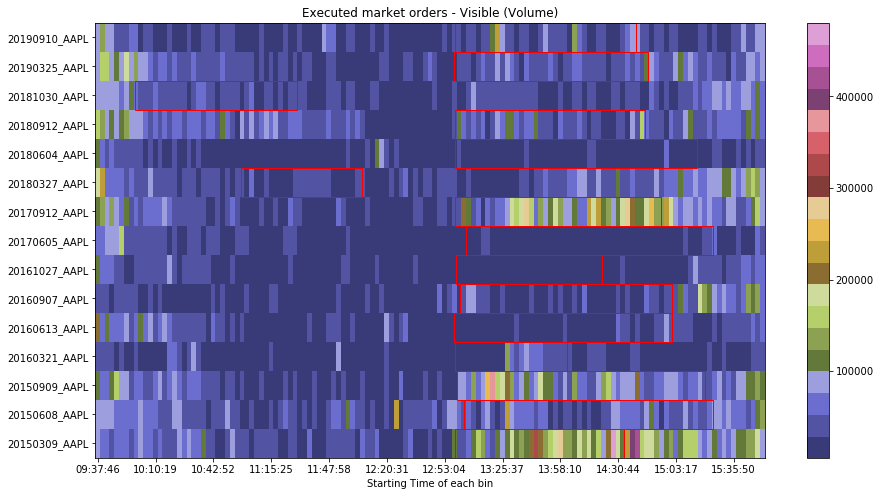

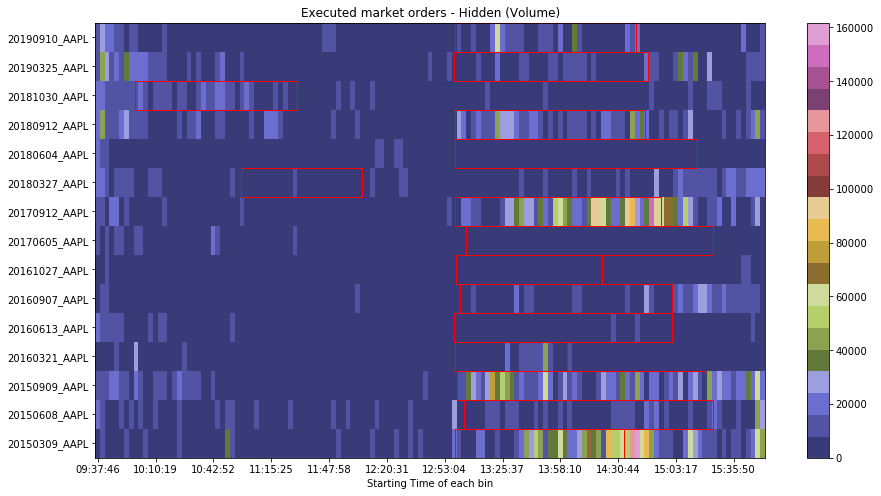

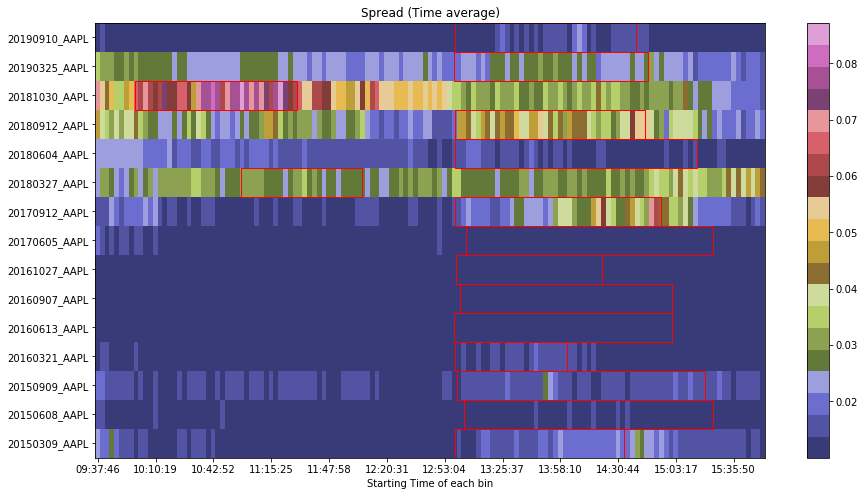

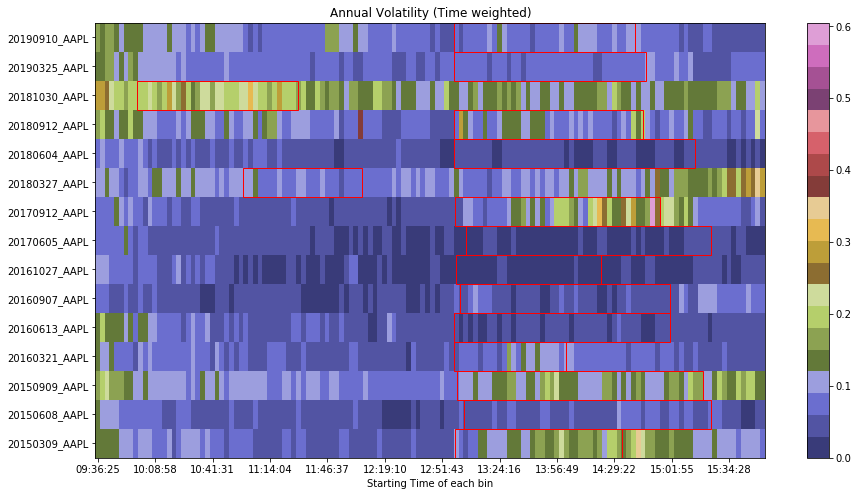

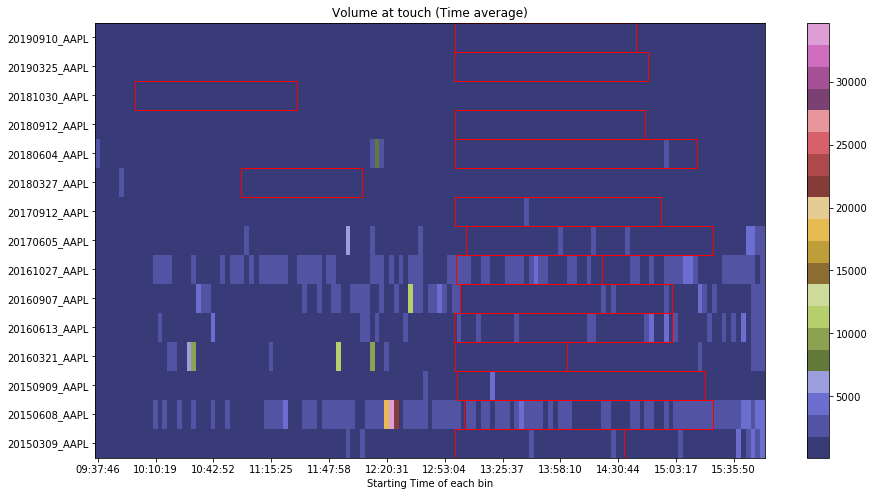

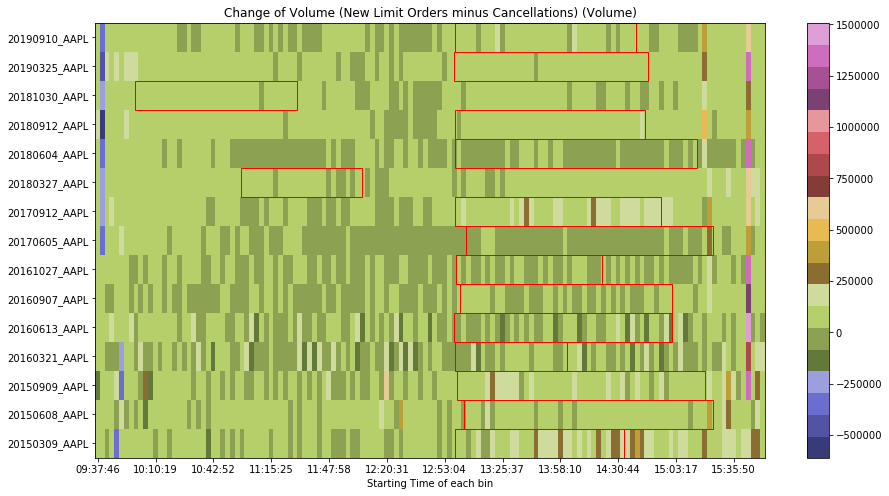

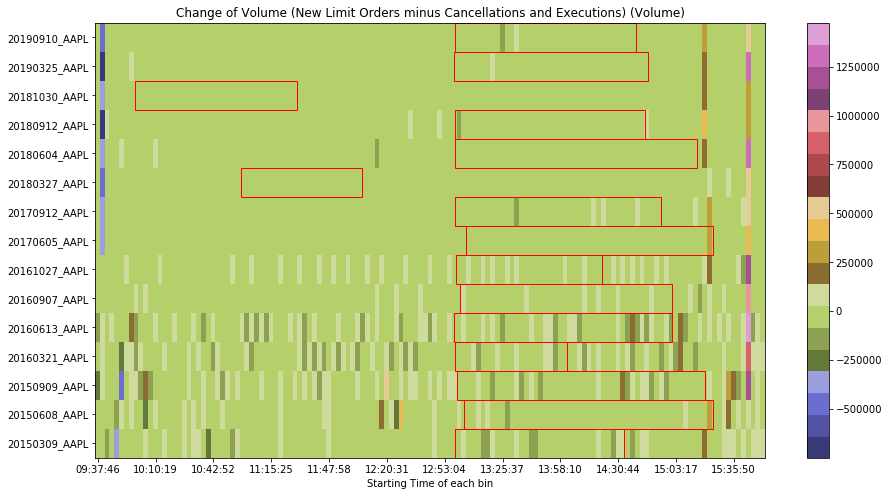

In [16]:
graphs_of_interest = ['marketorder_vis_num','marketorder_vis', 'marketorder_hid', 'spread','volatility','vol_touch','delta_volume','delta_volume_real',]
for i in graphs_of_interest:
    draw_graph_2d(sa.graphlist[i], filte)#, mapf=lambda x: np.log(x))#, mapf=lambda x: np.log(x))   

axis not same length


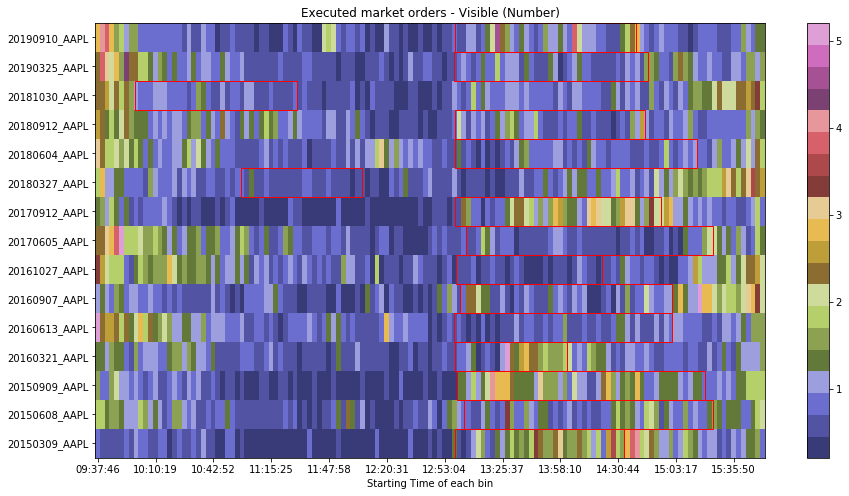

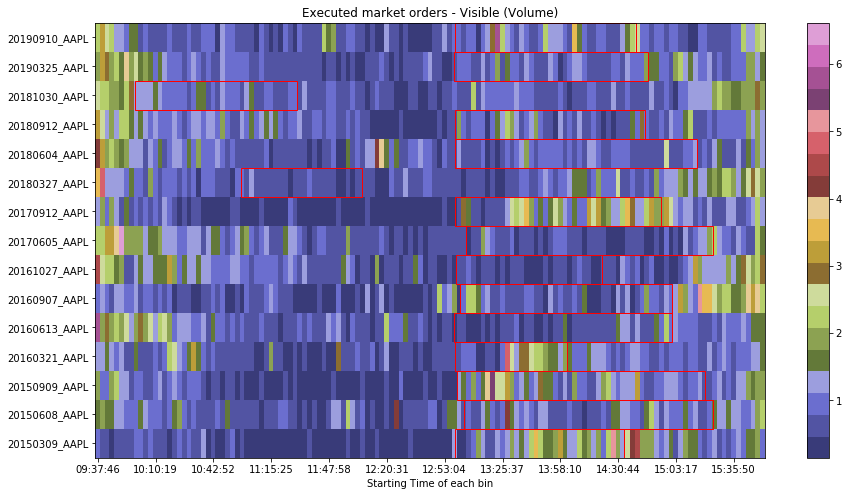

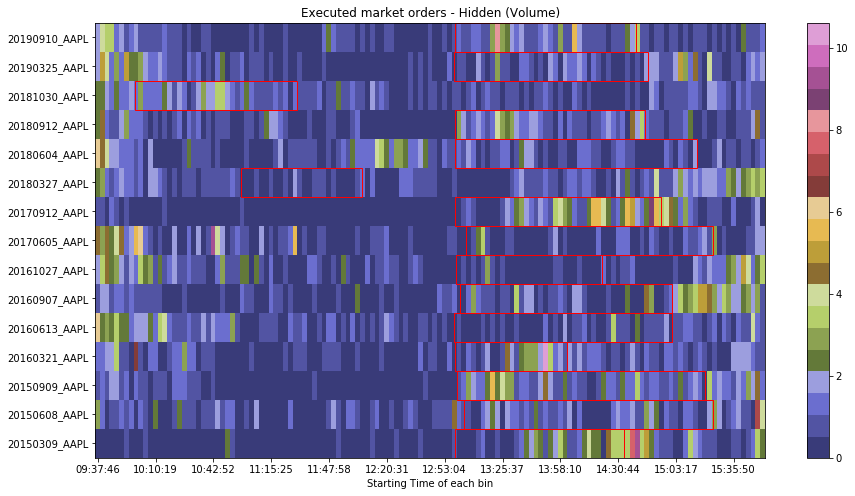

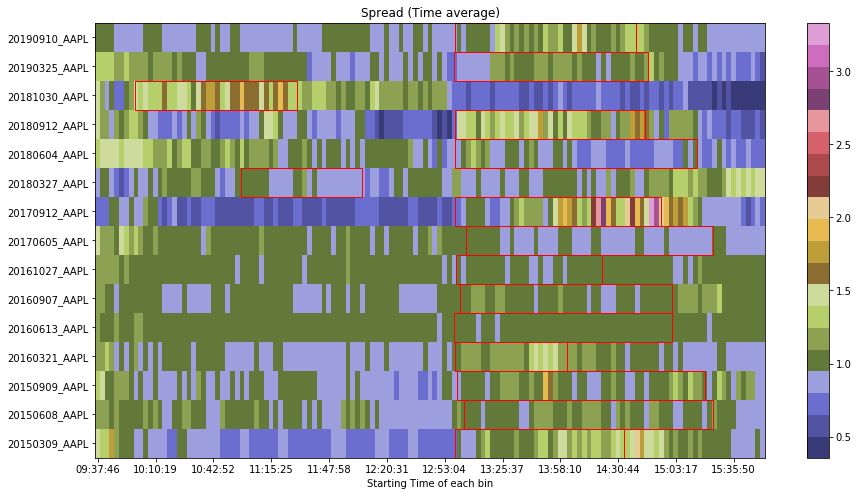

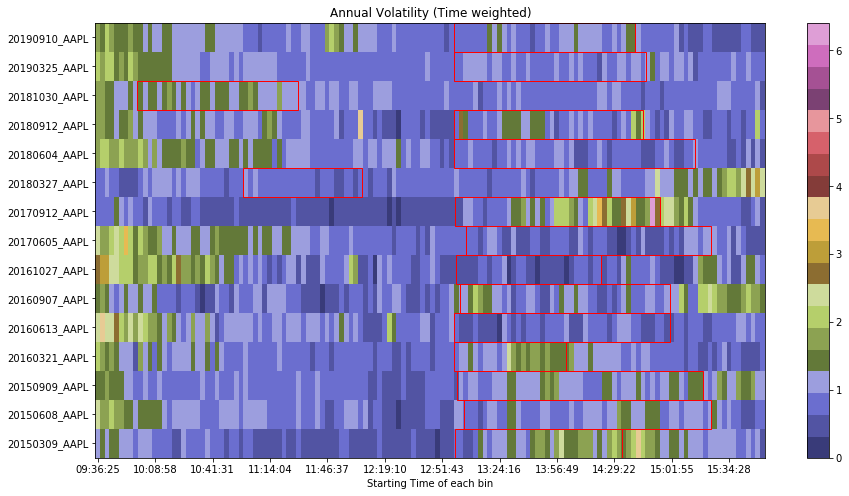

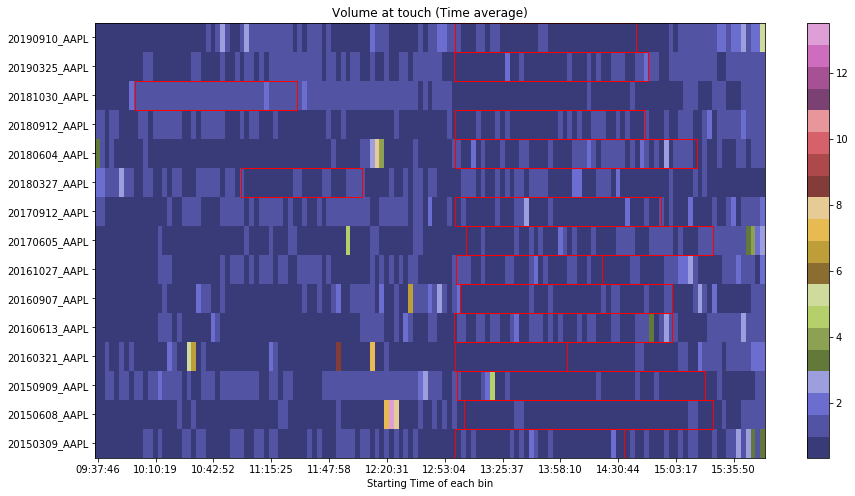

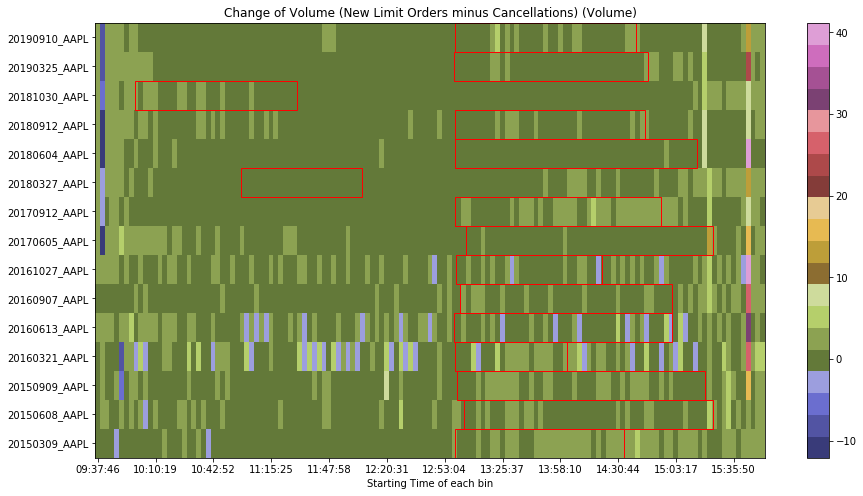

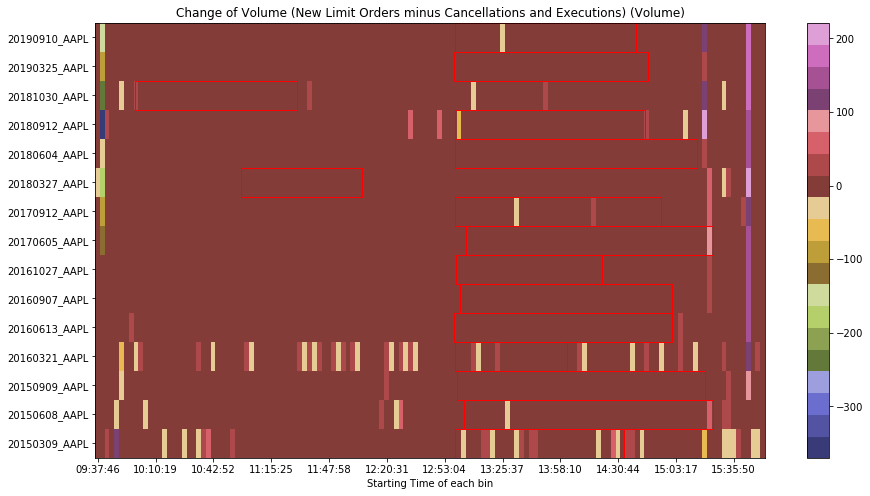

In [12]:
results = {}
graphs_of_interest = ['marketorder_vis_num','marketorder_vis', 'marketorder_hid', 'spread','volatility','vol_touch','delta_volume','delta_volume_real',]
for i in graphs_of_interest:
    results[i] = draw_graph_2d(sa.graphlist[i], filte, normalize=True)#, mapf=lambda x: np.log(x))#, mapf=lambda x: np.log(x))   

In [13]:
def get_weighted(a,b, r, indx):
    f = np.array([i>=salib.to_date_i(a) and i<salib.to_date_i(b) for i in r[1]])
    ts = np.array(r[1])[f][-1]-np.array(r[1])[f][0]
    return np.sum(r[0][indx][f])/ts.total_seconds()

axis not same length


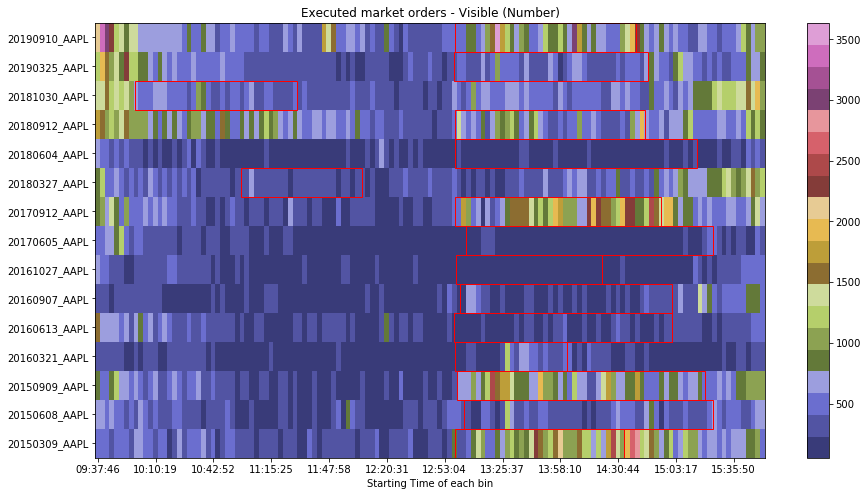

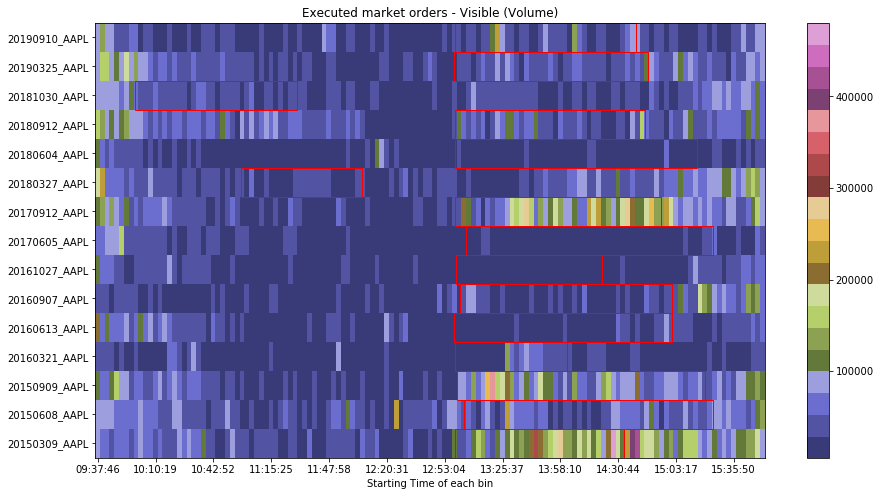

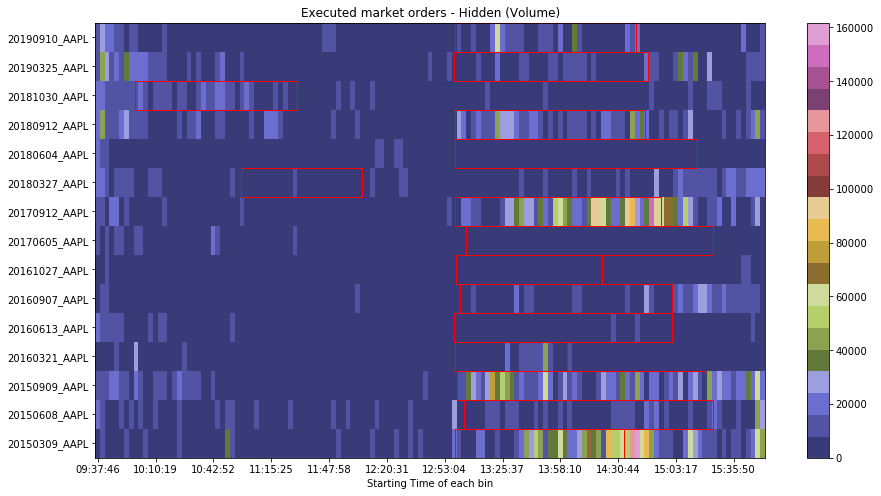

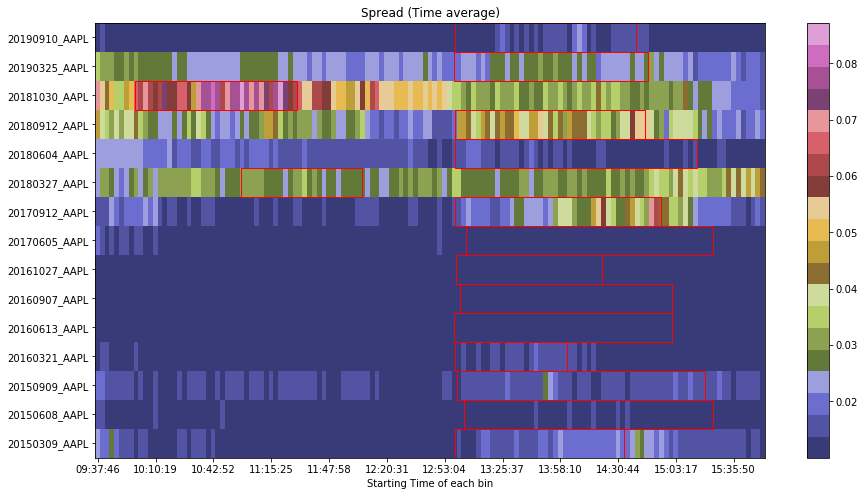

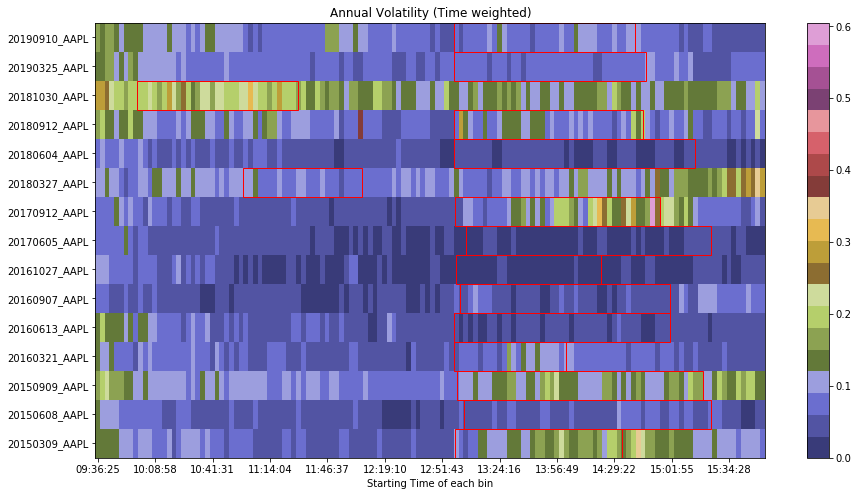

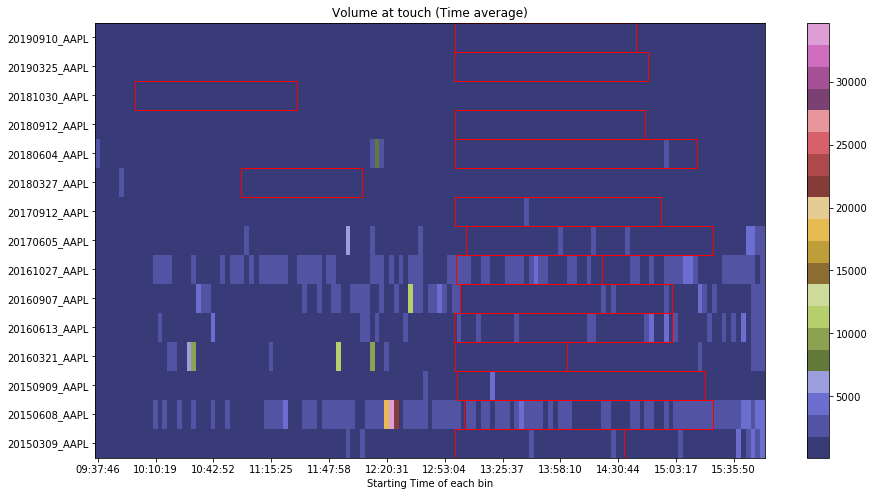

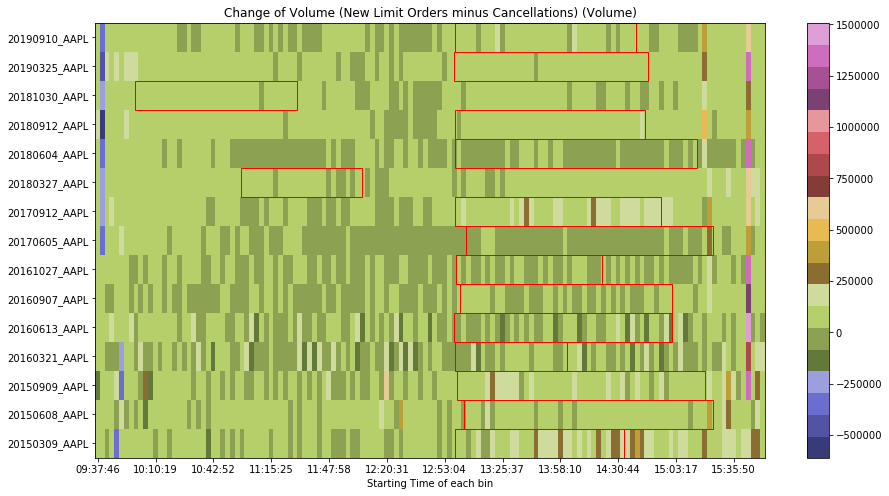

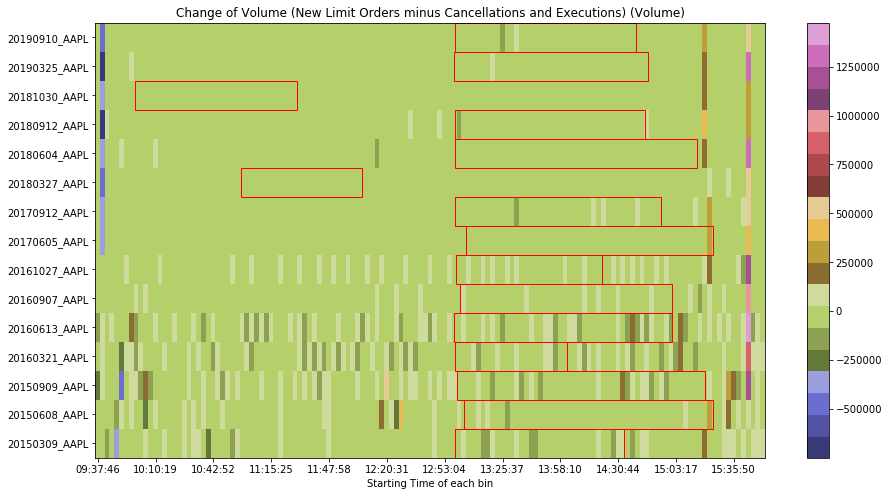

In [17]:
results = {}
graphs_of_interest = ['marketorder_vis_num','marketorder_vis', 'marketorder_hid', 'spread','volatility','vol_touch','delta_volume','delta_volume_real',]
for i in graphs_of_interest:
    results[i] = draw_graph_2d(sa.graphlist[i], filte, normalize=False)#, mapf=lambda x: np.log(x))#, mapf=lambda x: np.log(x))   

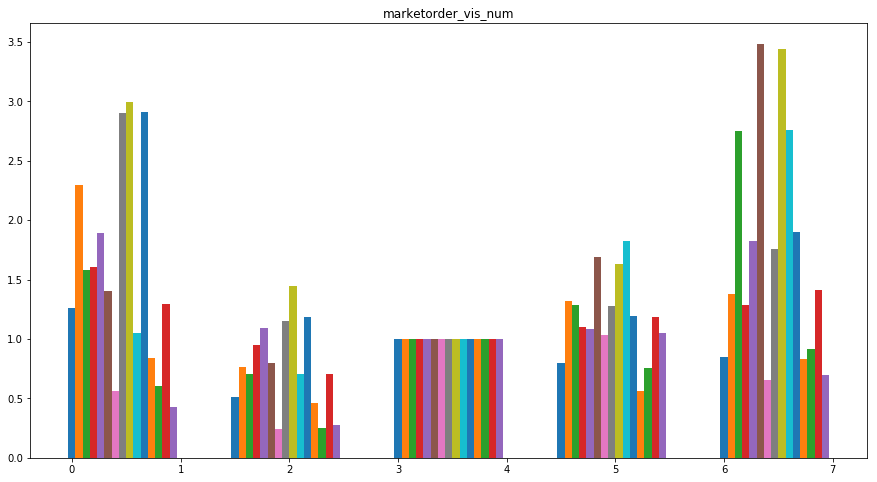

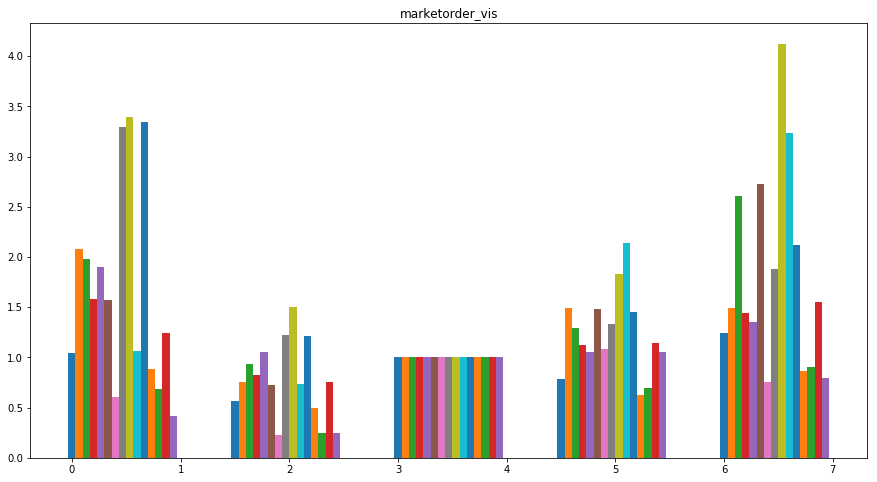

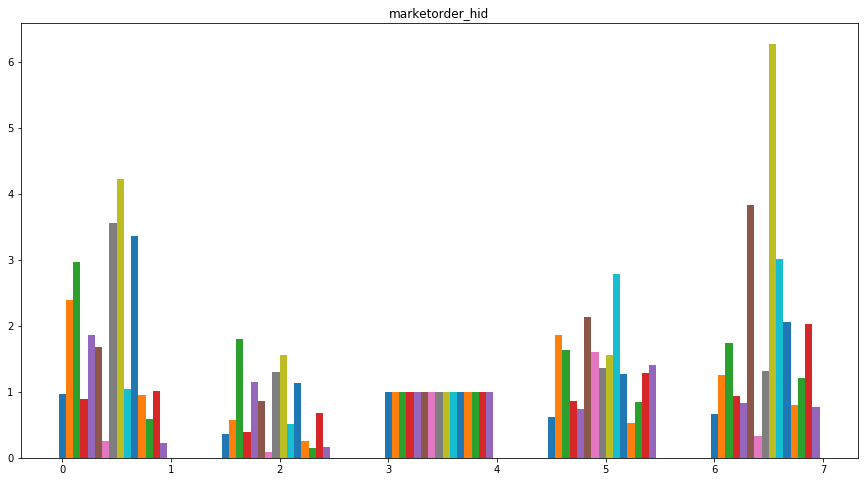

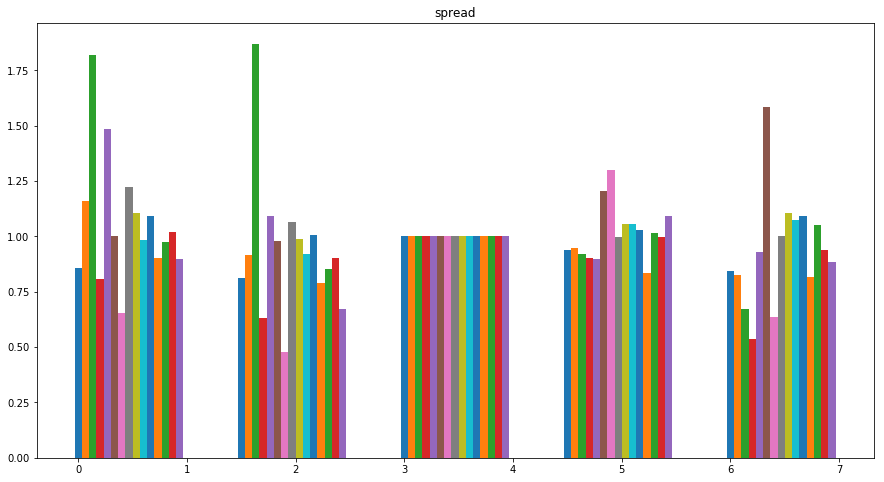

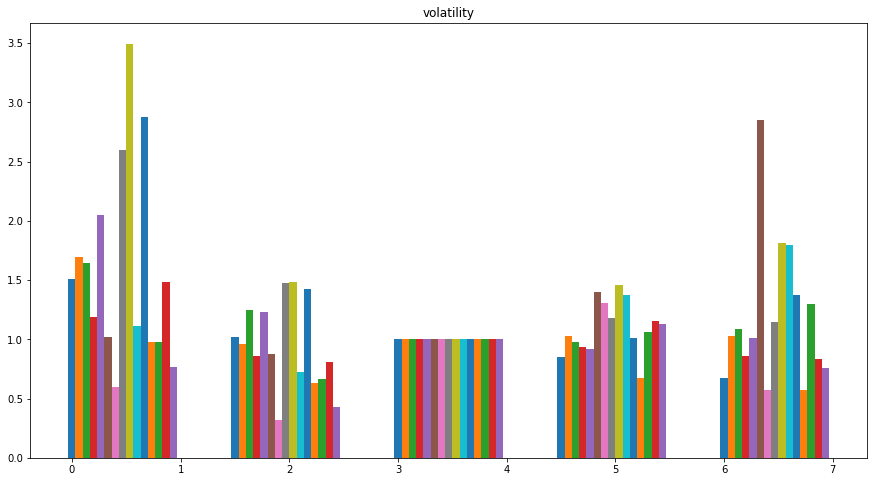

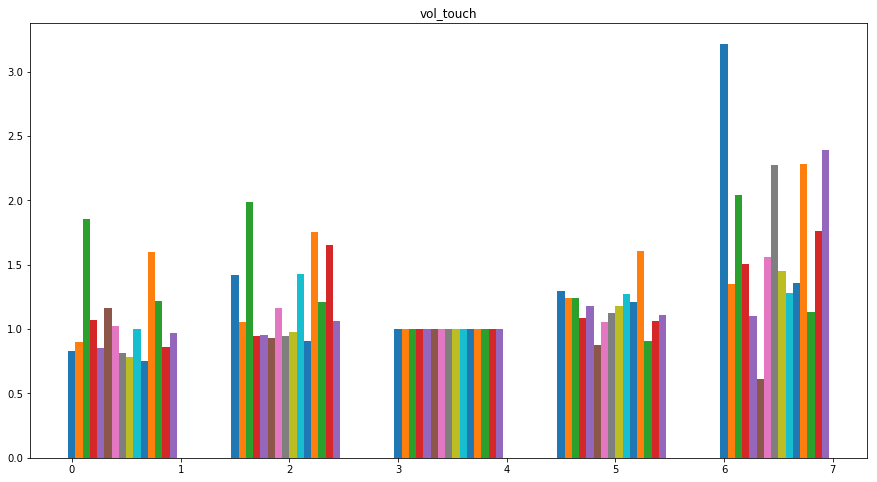

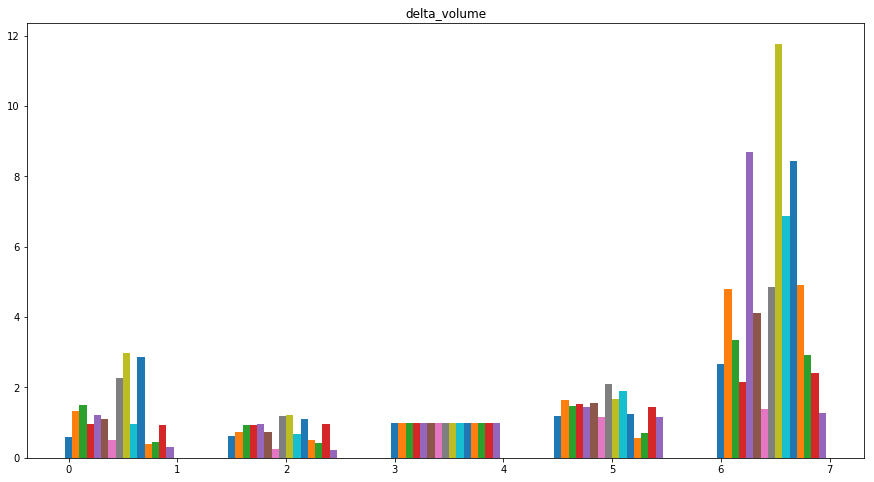

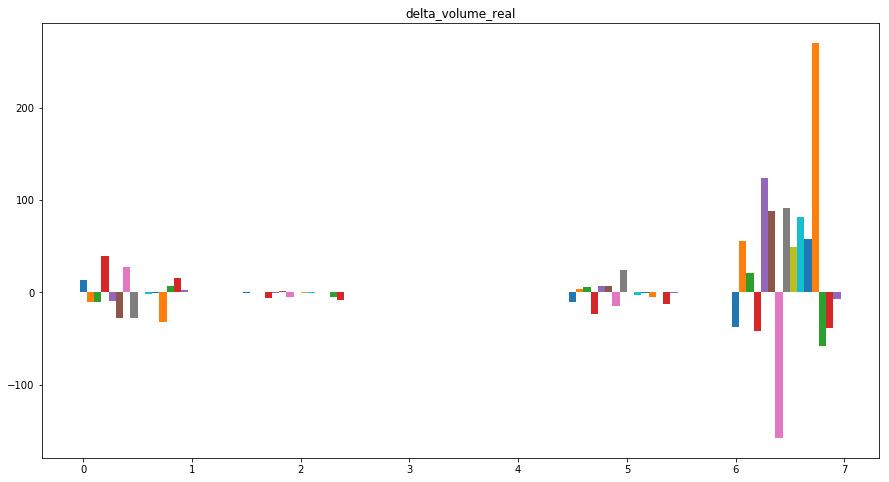

In [20]:
for v,k in results.items():#['marketorder_vis']
    for i in range(0,len(k[2])):
        yres = []
        yres.append ( get_weighted(9.6,10.5*3600*1000, k, i) )
        yres.append ( get_weighted(10.5*3600*1000, k[3], k, i) )
        yres.append ( get_weighted(k[3], k[4], k, i) )
        yres.append ( get_weighted(k[4], 15.5*3600*1000, k, i) )
        yres.append ( get_weighted(15.5*3600*1000, 15.9*3600*1000, k, i) )
        
        yres = np.array(yres)/yres[2]
        #for j in range(10,16):
        #    yres.append ( get_weighted((j)*3600*1000, (j+1)*3600*1000, k, i) )
        w = 1/len(k[2])
        n = 1.5
        plt.bar([w*i, n+w*i, 2*n+w*i, 3*n+w*i, 4*n+w*i],yres, width = w)
        plt.title(v)
    plt.show()